In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor


### Hyperparameters

In [2]:
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

### Common Functions

In [3]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

### Load Data

In [4]:
# load data
df = pd.read_csv('data_df.csv')
df = df[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,Date,Open,High,Low,Close,Volume,Month
0,2010-01-04,32.43,33.055,32.38,32.98,14676800.0,1
1,2010-01-05,32.93,33.030,32.66,32.85,7512000.0,1
2,2010-01-06,32.45,32.980,32.36,32.56,11319600.0,1
3,2010-01-07,32.60,33.870,32.56,33.76,17940200.0,1
4,2010-01-08,33.67,34.410,33.51,34.00,21856500.0,1


### Plot Initial Data

Text(0, 0.5, 'Stock Price (USD)')

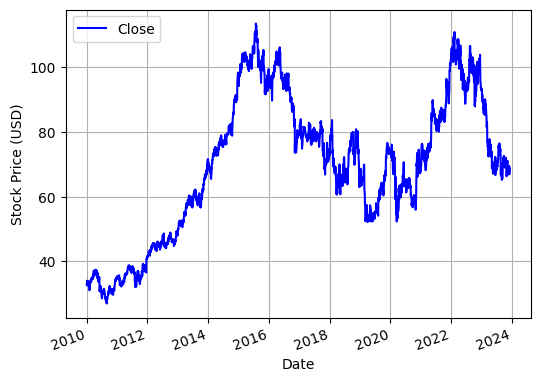

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 6, 4 # width 10, height 8

ax = df.plot(x='Date', y='Close', style='b-', grid=True)
ax.set_xlabel("Date")
#tilt the x label to 60 degree to make it fit
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.set_ylabel("Stock Price (USD)")

## Feature Engineering

We will generate the following features:

    - Mean 'adj_close' of each month
    - Difference between high and low of each day
    - Difference between open and close of each day
    - Mean volume of each month


In [6]:
# Get difference between high and low of each day
df['Range_HL'] = df['High'] - df['Low']
df.drop(['High', 'Low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['Range_OC'] = df['Open'] - df['Close']
df.drop(['Open'], axis=1, inplace=True)

df.head()

,Date,Close,Volume,Month,Range_HL,Range_OC
0,2010-01-04,32.98,14676800.0,1,0.675,-0.55
1,2010-01-05,32.85,7512000.0,1,0.370,0.08
2,2010-01-06,32.56,11319600.0,1,0.620,-0.11
3,2010-01-07,33.76,17940200.0,1,1.310,-1.16
4,2010-01-08,34.00,21856500.0,1,0.900,-0.33


> Create lags up to N number of days to use as features

In [7]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['Close', 'Range_HL', 'Range_OC', 'Volume']
lag_cols

['Close', 'Range_HL', 'Range_OC', 'Volume']

In [8]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,Date,Close,Volume,Month,Range_HL,Range_OC,order_day,Close_lag_1,Range_HL_lag_1,Range_OC_lag_1,Volume_lag_1,Close_lag_2,Range_HL_lag_2,Range_OC_lag_2,Volume_lag_2,Close_lag_3,Range_HL_lag_3,Range_OC_lag_3,Volume_lag_3
3,2010-01-07,33.76,17940200.0,1,1.31,-1.16,3,32.56,0.62,-0.11,11319600.0,32.85,0.37,0.08,7512000.0,32.98,0.675,-0.55,14676800.0
4,2010-01-08,34.00,21856500.0,1,0.90,-0.33,4,33.76,1.31,-1.16,17940200.0,32.56,0.62,-0.11,11319600.0,32.85,0.370,0.08,7512000.0
5,2010-01-11,33.93,9829000.0,1,0.44,0.25,5,34.00,0.90,-0.33,21856500.0,33.76,1.31,-1.16,17940200.0,32.56,0.620,-0.11,11319600.0
6,2010-01-12,33.56,11745000.0,1,0.54,0.30,6,33.93,0.44,0.25,9829000.0,34.00,0.90,-0.33,21856500.0,33.76,1.310,-1.16,17940200.0
7,2010-01-13,33.97,11407200.0,1,0.88,-0.60,7,33.56,0.54,0.30,11745000.0,33.93,0.44,0.25,9829000.0,34.00,0.900,-0.33,21856500.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 3 to 3502
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            3500 non-null   object 
 1   Close           3500 non-null   float64
 2   Volume          3500 non-null   float64
 3   Month           3500 non-null   int32  
 4   Range_HL        3500 non-null   float64
 5   Range_OC        3500 non-null   float64
 6   order_day       3500 non-null   int64  
 7   Close_lag_1     3500 non-null   float64
 8   Range_HL_lag_1  3500 non-null   float64
 9   Range_OC_lag_1  3500 non-null   float64
 10  Volume_lag_1    3500 non-null   float64
 11  Close_lag_2     3500 non-null   float64
 12  Range_HL_lag_2  3500 non-null   float64
 13  Range_OC_lag_2  3500 non-null   float64
 14  Volume_lag_2    3500 non-null   float64
 15  Close_lag_3     3500 non-null   float64
 16  Range_HL_lag_3  3500 non-null   float64
 17  Range_OC_lag_3  3500 non-null   f

### Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [10]:
for col in lag_cols:
    df = get_mov_avg_std(df, col, N)
df.head()

,Date,Close,Volume,Month,Range_HL,Range_OC,order_day,Close_lag_1,Range_HL_lag_1,Range_OC_lag_1,...,Range_OC_lag_3,Volume_lag_3,Close_mean,Close_std,Range_HL_mean,Range_HL_std,Range_OC_mean,Range_OC_std,Volume_mean,Volume_std
3,2010-01-07,33.76,17940200.0,1,1.31,-1.16,3,32.56,0.62,-0.11,...,-0.55,14676800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,34.00,21856500.0,1,0.90,-0.33,4,33.76,1.31,-1.16,...,0.08,7512000.0,33.760000,NaN,1.310000,NaN,-1.160000,NaN,1.794020e+07,NaN
5,2010-01-11,33.93,9829000.0,1,0.44,0.25,5,34.00,0.90,-0.33,...,-0.11,11319600.0,33.880000,0.169706,1.105000,0.289914,-0.745000,0.586899,1.989835e+07,2.769242e+06
6,2010-01-12,33.56,11745000.0,1,0.54,0.30,6,33.93,0.44,0.25,...,-1.16,17940200.0,33.896667,0.123423,0.883333,0.435239,-0.413333,0.708684,1.654190e+07,6.134462e+06
7,2010-01-13,33.97,11407200.0,1,0.88,-0.60,7,33.56,0.54,0.30,...,-0.33,21856500.0,33.830000,0.236432,0.626667,0.241937,0.073333,0.350190,1.447683e+07,6.462381e+06


## Train, Validation, Test Split

In [11]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2100
num_cv = 700
num_test = 700
train.shape = (2100, 27)
cv.shape = (700, 27)
train_cv.shape = (2800, 27)
test.shape = (700, 27)


### Scaling for Better Output

In [12]:
cols_to_scale = [
"Close"
]

for i in range(1,N+1):
    cols_to_scale.append("Close_lag_"+str(i))
    cols_to_scale.append("Range_HL_lag_"+str(i))
    cols_to_scale.append("Range_OC_lag_"+str(i))
    cols_to_scale.append("Volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['Date', 'Month']] = train.reset_index()[['Date', 'Month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 6.56354262e+01  6.56211976e+01  1.07047733e+00 -8.30747619e-03
  6.98299859e+06  6.56076929e+01  1.06983924e+00 -8.11700000e-03
  6.98226034e+06  6.55944881e+01  1.06936067e+00 -8.99319048e-03
  6.98429083e+06]
scaler.var_ = [5.97881830e+02 5.98397710e+02 6.97286274e-01 5.51232083e-01
 1.66104736e+13 5.98899667e+02 6.97324762e-01 5.51189498e-01
 1.66085475e+13 5.99395007e+02 6.97221486e-01 5.50526125e-01
 1.66311326e+13]
train_scaled.shape = (2100, 13)
train_scaled.shape = (2100, 15)


,Close,Close_lag_1,Range_HL_lag_1,Range_OC_lag_1,Volume_lag_1,Close_lag_2,Range_HL_lag_2,Range_OC_lag_2,Volume_lag_2,Close_lag_3,Range_HL_lag_3,Range_OC_lag_3,Volume_lag_3,Date,Month
0,-1.303612,-1.351524,-0.539470,-0.136969,1.064041,-1.338555,-0.838071,0.118689,0.129986,-1.332153,-0.472289,-0.729145,1.886284,2010-01-07,1
1,-1.293797,-1.302468,0.286841,-1.551205,2.688491,-1.350405,-0.538691,-0.137231,1.064284,-1.337463,-0.837560,0.119941,0.129400,2010-01-08,1
2,-1.296659,-1.292657,-0.204156,-0.433285,3.649406,-1.301370,0.287597,-1.551522,2.688828,-1.349308,-0.538158,-0.136132,1.063063,2010-01-11,1
3,-1.311791,-1.295519,-0.755029,0.347912,0.698303,-1.291563,-0.203386,-0.433558,3.649799,-1.300293,0.288192,-1.551275,2.686504,2010-01-12,1
4,-1.295024,-1.310644,-0.635274,0.415257,1.168419,-1.294424,-0.754245,0.347669,0.698525,-1.290490,-0.202828,-0.432639,3.646822,2010-01-13,1


In [13]:
# Do scaling for train+cv set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['Date', 'Month']] = train_cv.reset_index()[['Date', 'Month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 6.55586696e+01  6.55451268e+01  1.18868632e+00 -7.19892857e-04
  7.44196258e+06  6.55317089e+01  1.18841489e+00 -1.04132143e-03
  7.44231302e+06  6.55179446e+01  1.18806668e+00 -1.64132143e-03
  7.44493542e+06]
scaler_train_cv.var_ = [4.61859731e+02 4.62239795e+02 7.39286989e-01 6.62334698e-01
 1.81255630e+13 4.62612903e+02 7.39525059e-01 6.61993417e-01
 1.81252681e+13 4.62978340e+02 7.39542986e-01 6.61643808e-01
 1.81439491e+13]
train_cv_scaled.shape = (2800, 13)
train_cv_scaled.shape = (2800, 15)


,Close,Close_lag_1,Range_HL_lag_1,Range_OC_lag_1,Volume_lag_1,Close_lag_2,Range_HL_lag_2,Range_OC_lag_2,Volume_lag_2,Close_lag_3,Range_HL_lag_3,Range_OC_lag_3,Volume_lag_3,Date,Month
0,-1.479633,-1.534209,-0.661403,-0.134277,0.910797,-1.519483,-0.951693,0.099605,0.016369,-1.512202,-0.596612,-0.674144,1.697792,2010-01-07,1
1,-1.468465,-1.478394,0.141092,-1.424458,2.465873,-1.532966,-0.660981,-0.133917,0.910722,-1.518244,-0.951277,0.100369,0.015744,2010-01-08,1
2,-1.471722,-1.467231,-0.335753,-0.404601,3.385751,-1.477174,0.141385,-1.424430,2.465810,-1.531721,-0.660568,-0.133215,0.909637,2010-01-11,1
3,-1.488939,-1.470487,-0.870750,0.308070,0.560678,-1.466016,-0.335383,-0.404310,3.385696,-1.475951,0.141788,-1.424069,2.463925,2010-01-12,1
4,-1.469861,-1.487697,-0.754446,0.369508,1.010717,-1.469270,-0.870294,0.308545,0.560600,-1.464797,-0.334974,-0.403679,3.383337,2010-01-13,1


In [14]:
# Do scaling for CV set
cv_scaled = cv[['Date']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire CV set is scaled
cv_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,Date,Close_lag_1,Close_lag_2,Close_lag_3,Range_HL_lag_1,Range_HL_lag_2,Range_HL_lag_3,Range_OC_lag_1,Range_OC_lag_2,Range_OC_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
2103,2018-05-11,1.108241,-0.273316,-0.834925,1.151786,-0.504893,-0.646894,-0.762131,-0.370178,1.132309,0.355352,-1.129145,0.773793
2104,2018-05-14,1.067610,-0.152811,-0.914799,1.148111,-0.467373,-0.680738,-1.102646,0.254457,0.848189,1.140414,-0.413390,-0.727024
2105,2018-05-15,1.031752,-0.066859,-0.964893,-0.419540,1.141430,-0.721890,-0.884255,-0.200967,1.085222,-0.079093,1.037198,-0.958105
2106,2018-05-16,0.123764,0.932357,-1.056121,-0.879509,-0.208202,1.087711,1.138330,-0.736954,-0.401377,-1.092120,0.221320,0.870800
2107,2018-05-17,-0.264854,-0.840912,1.105766,-0.839665,-0.266624,1.106289,0.337767,0.787377,-1.125145,-0.651827,-0.499520,1.151347


In [15]:
# Do scaling for test set
test_scaled = test[['Date']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,Date,Close_lag_1,Close_lag_2,Close_lag_3,Range_HL_lag_1,Range_HL_lag_2,Range_HL_lag_3,Range_OC_lag_1,Range_OC_lag_2,Range_OC_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
2803,2021-02-23,-0.528166,-0.625176,1.153341,-0.305161,-0.811866,1.117027,-1.148365,0.469574,0.678791,-0.962564,-0.071079,1.033643
2804,2021-02-24,-1.152332,0.640184,0.512148,0.886401,0.197673,-1.084075,-0.350465,-0.777595,1.128060,1.109363,-0.832144,-0.277219
2805,2021-02-25,0.488918,-1.150395,0.661477,-1.066638,0.916349,0.150290,-1.037118,0.958207,0.078911,-0.598502,1.154439,-0.555937
2806,2021-02-26,-0.835535,1.107993,-0.272457,0.958576,-1.036827,0.078251,0.994204,-1.005697,0.011494,-0.761403,-0.371095,1.132499
2807,2021-03-01,-1.018533,0.038158,0.980375,-0.058747,1.028079,-0.969331,0.841822,0.263561,-1.105383,1.144978,-0.701983,-0.442995


### Split into X and y

In [16]:
features = []
for i in range(1,N+1):
    features.append("Close_lag_"+str(i))
    features.append("Range_HL_lag_"+str(i))
    features.append("Range_OC_lag_"+str(i))
    features.append("Volume_lag_"+str(i))

target = "Close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (2100, 12)
y_train.shape = (2100,)
X_cv.shape = (700, 12)
y_cv.shape = (700,)
X_train_cv.shape = (2800, 12)
y_train_cv.shape = (2800,)
X_sample.shape = (700, 12)
y_sample.shape = (700,)


In [17]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (2100, 12)
y_train_scaled.shape = (2100,)
X_cv_scaled.shape = (700, 12)
X_train_cv_scaled.shape = (2800, 12)
y_train_cv_scaled.shape = (2800,)
X_sample_scaled.shape = (700, 12)


## Verifying the split works

Text(0.5, 1.0, 'Without scaling')

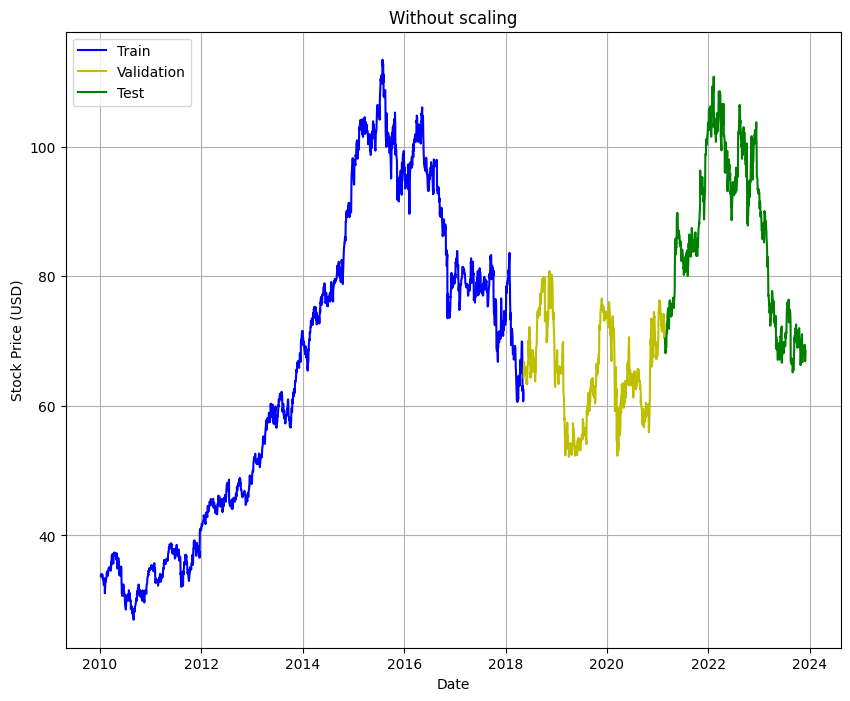

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Validation', 'Test'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
ax.set_title("Without scaling")
# plt.show()

Text(0.5, 1.0, 'With scaling')

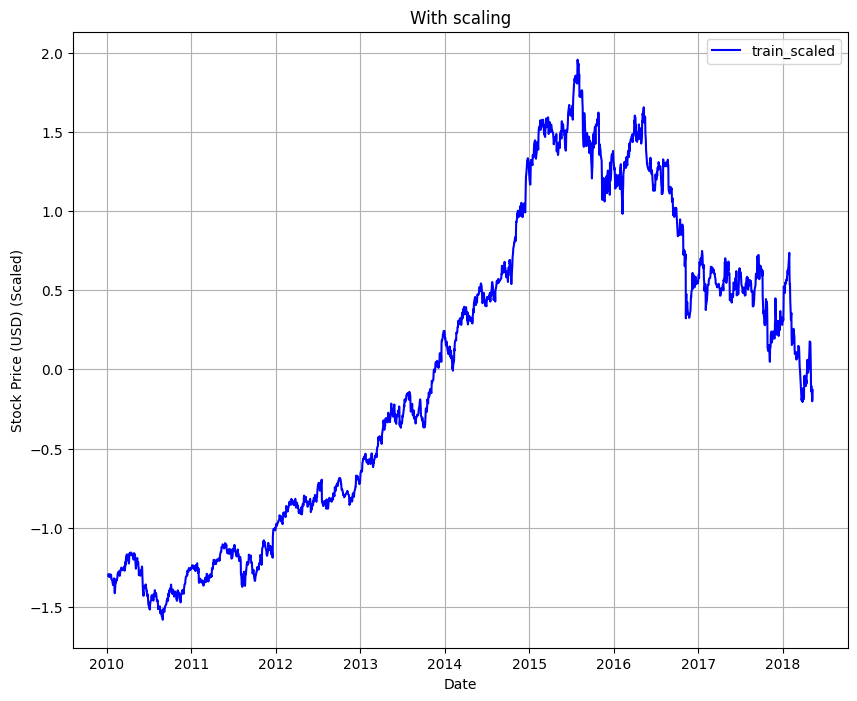

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='Date', y='Close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD) (Scaled)")
ax.set_title("With scaling")

## Model Fitting

In [20]:
# Create Model
model = XGBRegressor(seed=model_seed,
                     base_score=0.5,
                     booster='gbtree',
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the model
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
# Predicting on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_train, est))
print(f"RMSE on training set = {rmse:0.3f}")

# Calculate MAPE
mape = get_mape(y_train, est)
print(f"MAPE on training set = {mape:0.3f}%")

RMSE on training set = 0.757
MAPE on training set = 0.861%


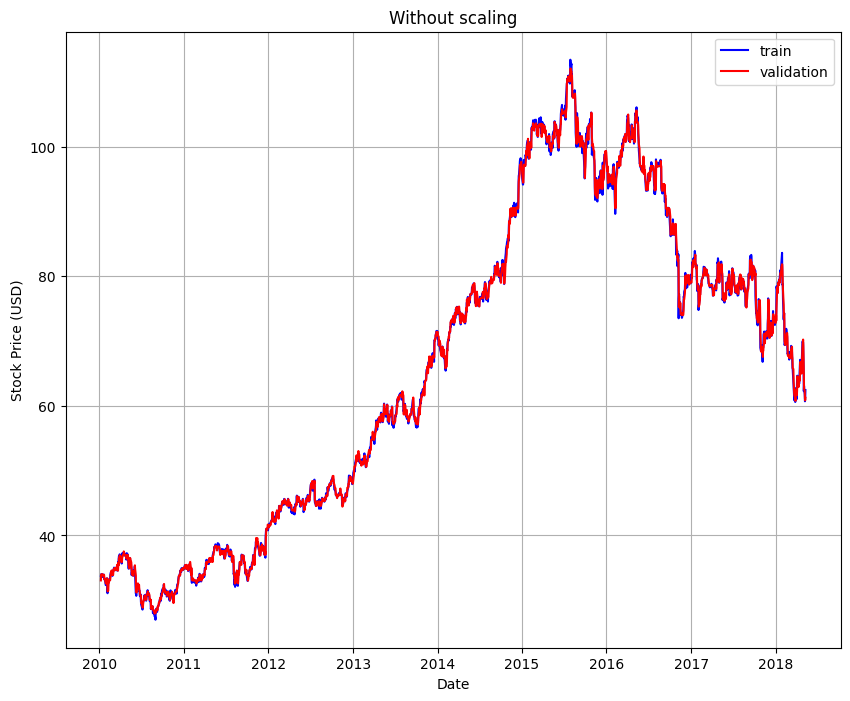

In [22]:
# Plot Close over time with predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                          'Date': train['Date']})

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
# ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
# ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
ax.set_title("Without scaling")
plt.show()


## Predict on Validation Set

In [23]:
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['Close_std'] + cv['Close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(cv['Close'], cv['est']))
print(f"RMSE on CV set = {rmse_bef_tuning:0.3f}")

# Calculate MAPE
mape = get_mape(cv['Close'], cv['est'])
print(f"MAPE on CV set = {mape:0.3f}%")

RMSE on CV set = 1.322
MAPE on CV set = 1.437%


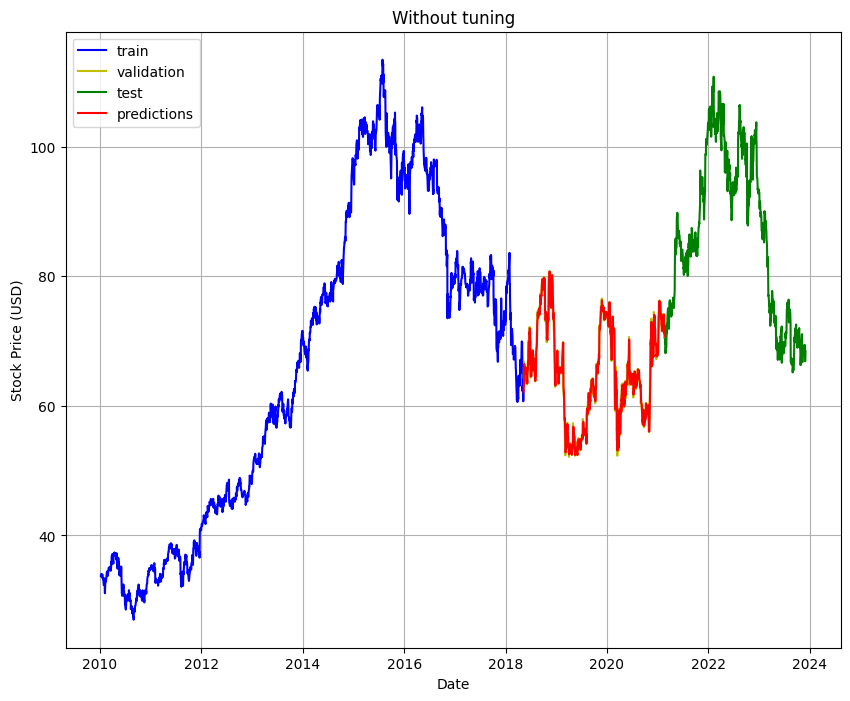

In [24]:
# Plot Close over time with predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'],
                       'Date' : cv['Date'],
                       'y_cv': y_cv})

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
ax.set_title("Without tuning")
plt.show()

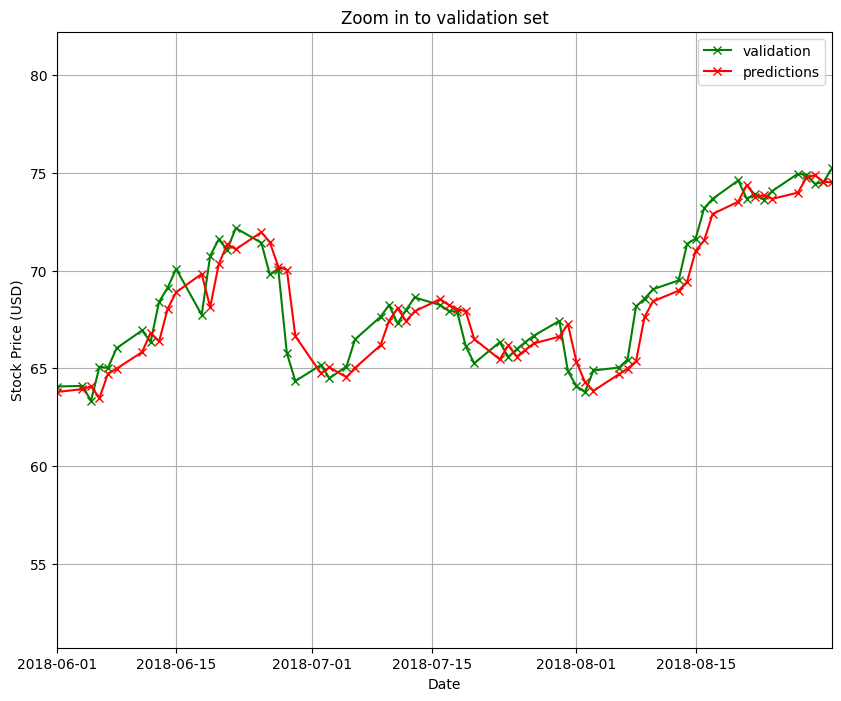

In [25]:
# Zoom in to only validation set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = cv.plot(x='Date', y='Close', style='gx-', grid=True)
ax = est_df.plot(x='Date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['validation', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
ax.set_xlim([date(2018, 6, 1), date(2018, 8, 31)])
ax.set_title("Zoom in to validation set")
plt.show()

> This model successfully capture every direction change with a slight lag

### Find out feature importances

In [26]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('Volume_lag_2', 0.00011481744),
 ('Range_OC_lag_2', 0.00011945883),
 ('Range_HL_lag_2', 0.00013187554),
 ('Range_HL_lag_1', 0.00013368123),
 ('Range_OC_lag_1', 0.00014213084),
 ('Volume_lag_3', 0.00015771491),
 ('Range_HL_lag_3', 0.00017166135),
 ('Close_lag_3', 0.022428125),
 ('Close_lag_2', 0.33877167),
 ('Close_lag_1', 0.63762766)]

> Close price with various lag value dominates the model decision

In [27]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['Close_mean'],
                             test['Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             learning_rate=learning_rate, 
                             min_child_weight=min_child_weight, 
                             subsample=subsample, 
                             colsample_bytree=colsample_bytree, 
                             colsample_bylevel=colsample_bylevel, 
                             gamma=gamma)

# Calculate RMSE
print(f'RMSE on test set = {rmse:.3f}')

# Calculate MAPE
print(f"MAPE on test set = {mape:.3f}%")

RMSE on test set = 1.342
MAPE on test set = 1.107%


In [30]:
test

,Date,Close,Volume,Month,Range_HL,Range_OC,order_day,Close_lag_1,Range_HL_lag_1,Range_OC_lag_1,...,Range_OC_lag_3,Volume_lag_3,Close_mean,Close_std,Range_HL_mean,Range_HL_std,Range_OC_mean,Range_OC_std,Volume_mean,Volume_std
2803,2021-02-23,69.64,8150567.0,2,1.3400,0.08,2803,70.48,1.2666,-0.18,...,1.13,7334086.0,70.806667,0.618493,1.348867,0.269585,0.643333,0.716961,6.582451e+06,7.271705e+05
2804,2021-02-24,70.40,5826060.0,2,1.1500,-0.51,2804,69.64,1.3400,0.08,...,0.98,6530765.0,70.180000,0.468615,1.245533,0.106573,0.293333,0.608714,6.854612e+06,1.168198e+06
2805,2021-02-25,69.33,5222657.0,2,1.4900,0.65,2805,70.40,1.1500,-0.51,...,-0.18,5882503.0,70.173333,0.463609,1.252200,0.095815,-0.203333,0.295691,6.619710e+06,1.326061e+06
2806,2021-02-26,68.13,9525793.0,2,1.3050,1.14,2806,69.33,1.4900,0.65,...,0.08,8150567.0,69.790000,0.550545,1.326667,0.170392,0.073333,0.580029,6.399761e+06,1.545967e+06
2807,2021-03-01,69.28,5659548.0,3,1.3100,-0.86,2807,68.13,1.3050,1.14,...,-0.51,5826060.0,69.286667,1.135620,1.315000,0.170220,0.426667,0.847368,6.858170e+06,2.329846e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,2023-11-27,68.74,6334283.0,11,0.9950,0.63,3498,69.42,0.7350,-0.67,...,0.36,4829444.0,68.880000,0.706824,0.828333,0.082209,-0.370000,0.635531,3.822401e+06,1.406117e+06
3499,2023-11-28,69.32,4291910.0,11,0.9300,-0.46,3499,68.74,0.9950,0.63,...,-0.80,4421860.0,69.100000,0.341760,0.873333,0.130799,-0.280000,0.790759,4.324014e+06,2.060934e+06
3500,2023-11-29,66.90,9856309.0,11,2.0600,1.84,3500,69.32,0.9300,-0.46,...,-0.67,2215900.0,69.160000,0.367151,0.886667,0.135308,-0.166667,0.697878,4.280698e+06,2.059214e+06
3501,2023-11-30,67.95,12331263.0,11,1.3372,-0.85,3501,66.90,2.0600,1.84,...,0.63,6334283.0,68.320000,1.263487,1.328333,0.634475,0.670000,1.150522,6.827501e+06,2.814797e+06


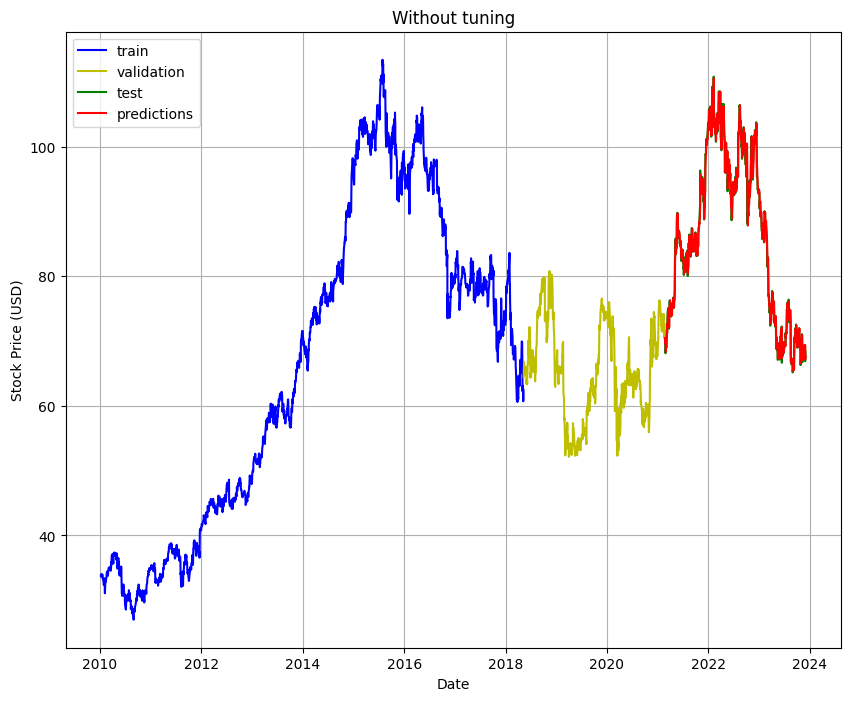

In [28]:
# Plot Close over time with predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                       'Date' : test['Date'],
                       'y_sample': y_sample})

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
ax.set_title("Without tuning")
plt.show()


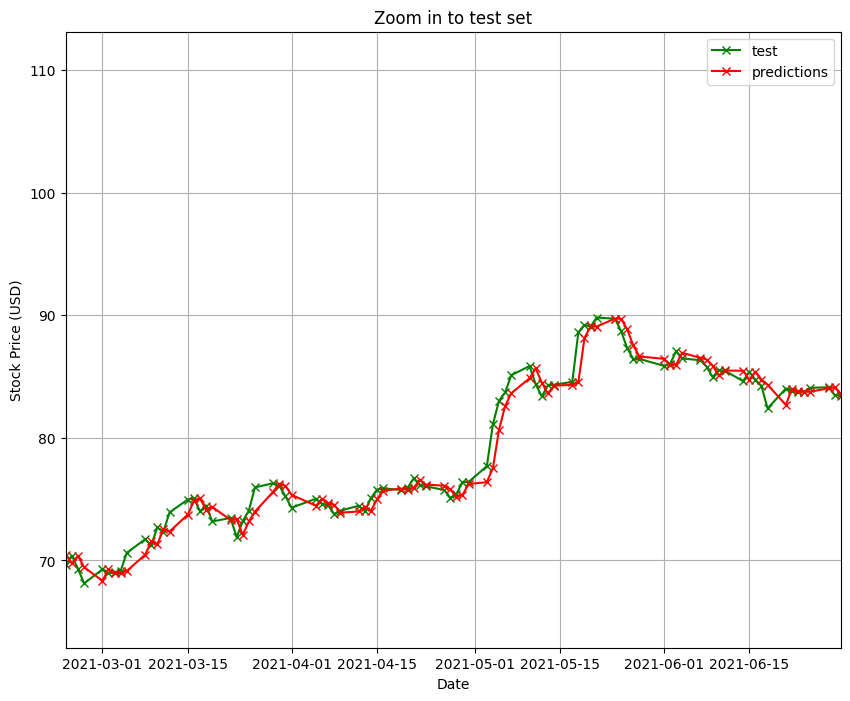

In [35]:
# Zoom in to only test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = test.plot(x='Date', y='Close', style='gx-', grid=True)
ax = est_df.plot(x='Date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price (USD)")
# 2021-02-23
ax.set_xlim([date(2021, 2, 23), date(2021, 6, 30)])
ax.set_title("Zoom in to test set")
plt.show()